Reproduction of the results obtained in Low-Rank Sinkhorn Factorization Meyer Scetbon, Marco Cuturi, Gabriel Peyré

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lot
from scipy.stats import norm

In [2]:
#Hyperparameters
N = [200,220]

# Minimal value (avoid zeros)
v_min = 0.02

# First distribution
mu0 = 0.3
std0 = 0.05

mu1 = 0.7
std1 = 0.06

X = np.arange(N[0]) / N[0]
a = norm.pdf(X, loc=mu0, scale=std0)
a += norm.pdf(X, loc=mu1, scale=std1)
a = (a + v_min * a.max())
a = a / a.sum()

# Second distribution
mu2= 0.6
std2= 0.06

mu3 = 0.4
std3 = 0.05

Y = np.arange(N[1]) / N[1]
b = norm.pdf(Y, loc=mu2, scale=std2)
b += norm.pdf(Y, loc=mu3, scale=std3)
b = (b + v_min * b.max())
b = b / b.sum()

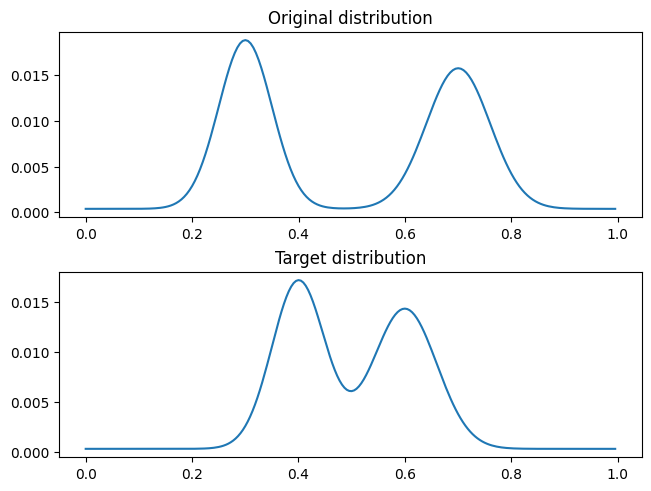

In [3]:
plt.figure(constrained_layout=True)
plt.subplot(211)
plt.title("Original distribution")
plt.plot(X, a)
plt.subplot(212)
plt.title("Target distribution")
plt.plot(Y, b)
plt.show()

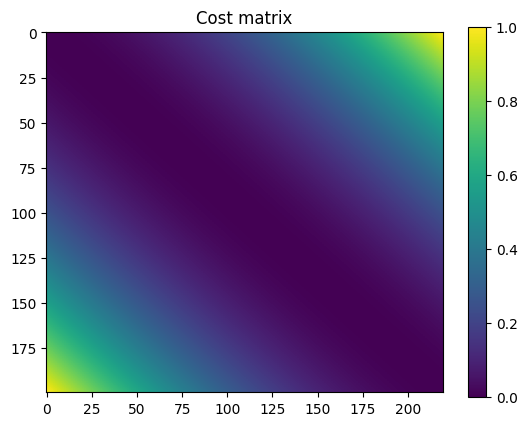

In [4]:
# Get the cost matrix
C = np.abs(X[:, None] - Y[None, :]) ** 2
C /= C.max()

plt.figure()
plt.title("Cost matrix")
plt.imshow(C)
plt.colorbar()
plt.show()

# Sinkhorn algorithm

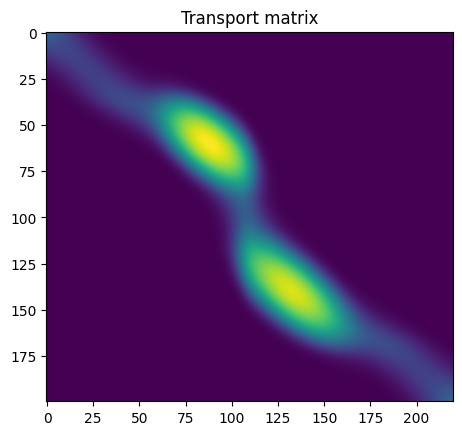

In [5]:
epsilon = 0.005

P, err_p, err_q, times, cost = lot.sinkhorn(a, b, C, epsilon, max_time=5)

plt.figure()
plt.title("Transport matrix")
plt.imshow(np.log(P+ 1e-5))
plt.show()

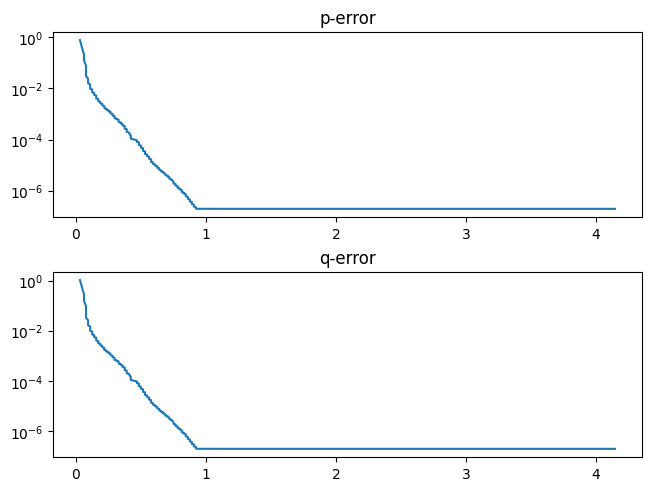

In [6]:
# Show convergence
plt.figure(constrained_layout=True)
plt.subplot(211)
plt.title("p-error")
plt.plot(times, err_p)
plt.semilogy()

plt.subplot(212)
plt.title("q-error")
plt.plot(times, err_q)
plt.semilogy()
plt.show()

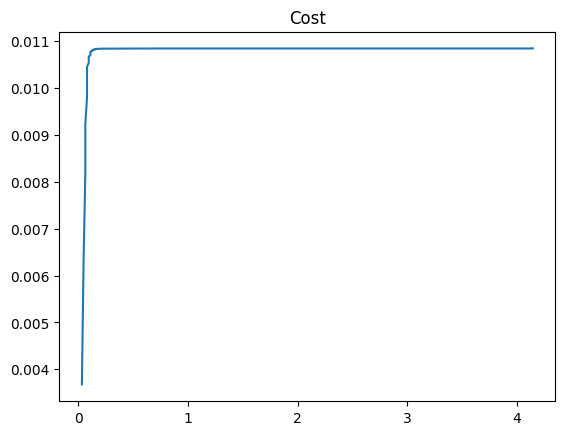

In [7]:
plt.figure()
plt.title("Cost")
plt.plot(times, cost)
plt.show()

In [8]:
## Compute the couplings obtained by Sinkhorn algorithm for multiple regularizations
P_Sin = []
epsilon_list = [0.001, 0.005, 0.05, 0.5]

for epsilon in epsilon_list:
    P, _, _, _, _ = lot.sinkhorn(
        a, b, C, epsilon, max_iter=100, delta=1e-9, lbd=0, max_time=50
    )
    P_Sin.append(P)

# Low-rank Method

In [9]:
## Compute the couplings obtained by LOT for multiple ranks
P_LOT = []
rank_list = [3, 10, 50, 100]

epsilon=0
alpha=1e-10
gamma=10
max_iter=1000
delta=1e-3
max_time=50
max_iter_dykstra=10000
delta_dykstra=1e-3
lbd_dykstra=0

for rank in rank_list:
    _, _, _, Q, R, g = lot.low_rank_ot(
        a, b, rank, C,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    P = Q / g @ R.T
    P_LOT.append(P)

C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: divide by zero encountered in log
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))
C:\Users\Emeric\PycharmProjects\OPT\lot.py:169: RuntimeWarning: invalid value encountered in multiply
  return np.sum(X * (np.log(X + lbd) - np.log(Y + lbd)))


Break: criterion is nan at iter  165
Break: criterion is nan at iter  143
Break: criterion is nan at iter  115
Break: criterion is nan at iter  105


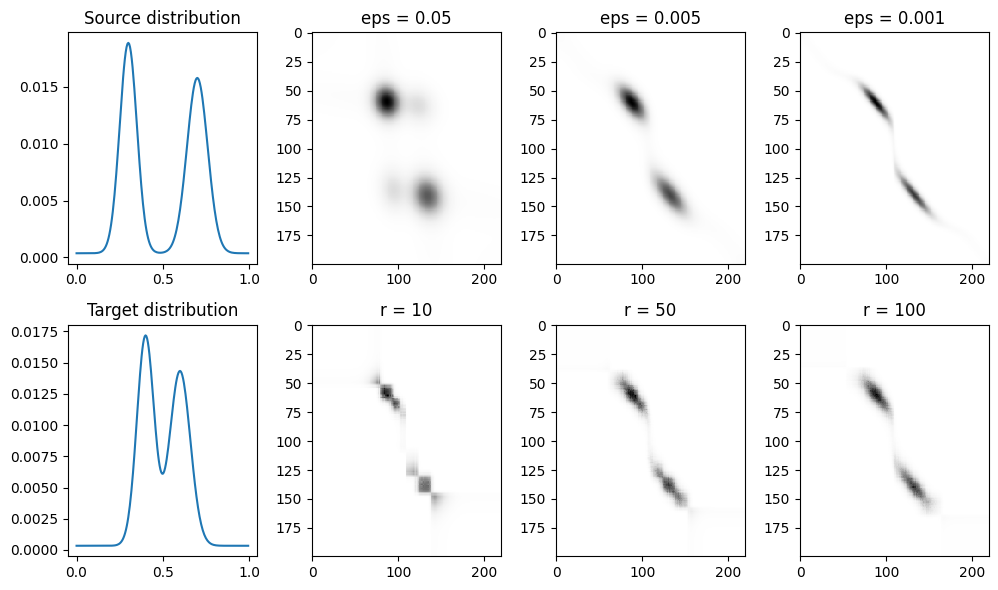

In [11]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6), constrained_layout=True)

axs[0, 0].plot(X, a)
axs[0, 0].set_title("Source distribution")
axs[1, 0].plot(Y, b)
axs[1, 0].set_title("Target distribution")

for i in range(1, 4):
    axs[0, i].imshow(P_Sin[-i-1], interpolation="nearest", cmap="Greys", aspect="auto")
    axs[0, i].set_title(f"eps = {epsilon_list[-i-1]}")

    axs[1, i].imshow(
            P_LOT[i], interpolation="nearest", cmap="Greys", aspect="auto"
        )
    axs[1, i].set_title(f"r = {rank_list[i]}")

plt.tight_layout()
plt.show()

# Linear LOT

In [15]:
## Compute the couplings obtained by LOT for multiple ranks
P_LOT = []
rank_list = [1, 3, 10, 50]

epsilon=0
alpha=1e-10
gamma=10
max_iter=1000
delta=1e-4
max_time=50
max_iter_dykstra=10000
delta_dykstra=1e-3
lbd_dykstra=0

# Get factorized cost matrices
p = np.power(X, 2)
q = np.power(Y, 2)
C1 = np.vstack((p, np.ones_like(p), -2 * X.T)).T
C2 = np.vstack((np.ones_like(q), q, Y.T)).T

for rank in rank_list:
    _, _, _, Q, R, g = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    P = Q / g @ R.T
    P_LOT.append(P)

Break: criterion is nan at iter  172
Break: criterion is nan at iter  140
Break: criterion is nan at iter  115


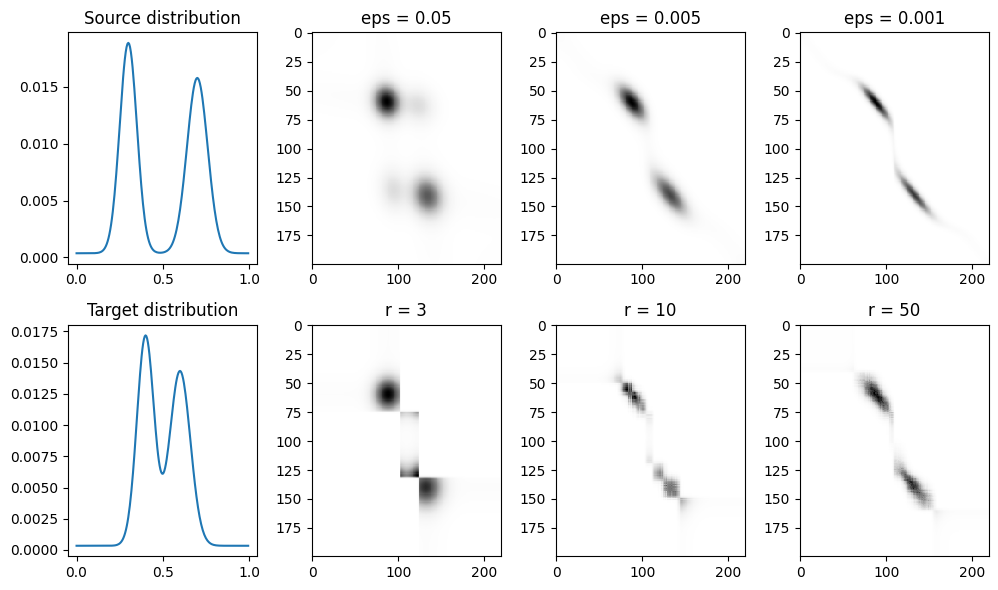

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(10, 6), constrained_layout=True)

axs[0, 0].plot(X, a)
axs[0, 0].set_title("Source distribution")
axs[1, 0].plot(Y, b)
axs[1, 0].set_title("Target distribution")

for i in range(1, 4):
    axs[0, i].imshow(P_Sin[-i-1], interpolation="nearest", cmap="Greys", aspect="auto")
    axs[0, i].set_title(f"eps = {epsilon_list[-i-1]}")

    axs[1, i].imshow(
            P_LOT[i], interpolation="nearest", cmap="Greys", aspect="auto"
        )
    axs[1, i].set_title(f"r = {rank_list[i]}")

plt.tight_layout()
plt.savefig("result/path_sol")
plt.show()

# Gaussian data

In [54]:
# Generate gaussian data
N = [5000, 5000]
X = np.random.normal(loc=1, scale=1, size=(N[0], 2))
Y = np.random.normal(loc=0, scale=0.1, size=(N[1], 2))

# Compute cost matrices
p = np.power(np.linalg.norm(X, axis=-1, ord=2), 2)
q = np.power(np.linalg.norm(Y, axis=-1, ord=2), 2)

C = np.linalg.norm(X[:, None] - Y[None, :], axis=-1, ord=2) ** 2
C1 = np.vstack((p, np.ones_like(p), -2 * X.T)).T
C2 = np.vstack((np.ones_like(q), q, Y.T)).T

# Uniform distributions
a = np.ones(N[0]) / N[0]
b = np.ones(N[1]) / N[1]

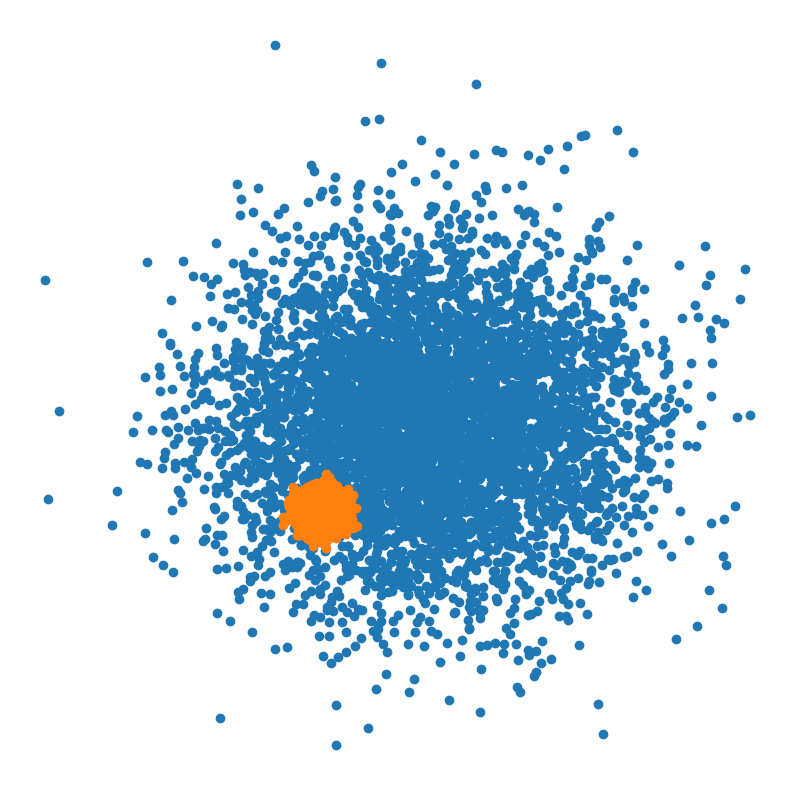

In [55]:
# Display the clouds
plt.figure(figsize=(10,10))
plt.scatter(X[:,0], X[:, 1])
plt.scatter(Y[:,0], Y[:, 1])
plt.axis("off")
plt.show()

In [56]:
epsilon = 0.01
alpha=1e-5

L = (2 / (alpha ** 4)) * (np.linalg.norm(C) ** 2)
L += ((epsilon + 2 * np.linalg.norm(C)) / (alpha ** 3)) ** 2
L = np.sqrt(3 * L)
gamma = 1 / L
print(f"gamma is {gamma}")

gamma is 1.1030396524188223e-20


In [57]:
alpha=1e-5
gamma_0 = 5
delta = 1e-5

max_time=100
epsilon = 0.01

# Sinkhorn
_, _, _, times_sin, cost_sin = lot.sinkhorn(a, b, C, epsilon=epsilon, max_time=max_time)

rank_list = [10, 50, 100, 300]
cost_lot = []
times_lot = []

for rank in rank_list:
    print(f"Rank {rank}:", end=" ")
    _, cost, times, _, _, _ = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma_0,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    cost_lot.append(cost)
    times_lot.append(times)
    print("done")

Rank 10: done
Rank 50: done
Rank 100: done
Rank 300: done


In [58]:
# Now for the un-penalized method
epsilon = 0
max_time=100
cost_lot_sec = []
times_lot_sec = []

for rank in rank_list:
    print(f"Rank {rank}:", end=" ")
    _, cost, times, _, _, _ = lot.low_rank_ot_linear(
        a, b, rank, C, C1, C2,
        alpha=alpha,
        epsilon=epsilon,
        max_time=max_time,
        gamma=gamma_0,
        delta=delta,
        max_iter_dykstra=max_iter_dykstra,
        delta_dykstra=delta_dykstra,
        lbd_dykstra=lbd_dykstra
    )

    cost_lot_sec.append(cost)
    times_lot_sec.append(times)
    print("done")

Rank 10: done
Rank 50: done
Rank 100: done
Rank 300: done


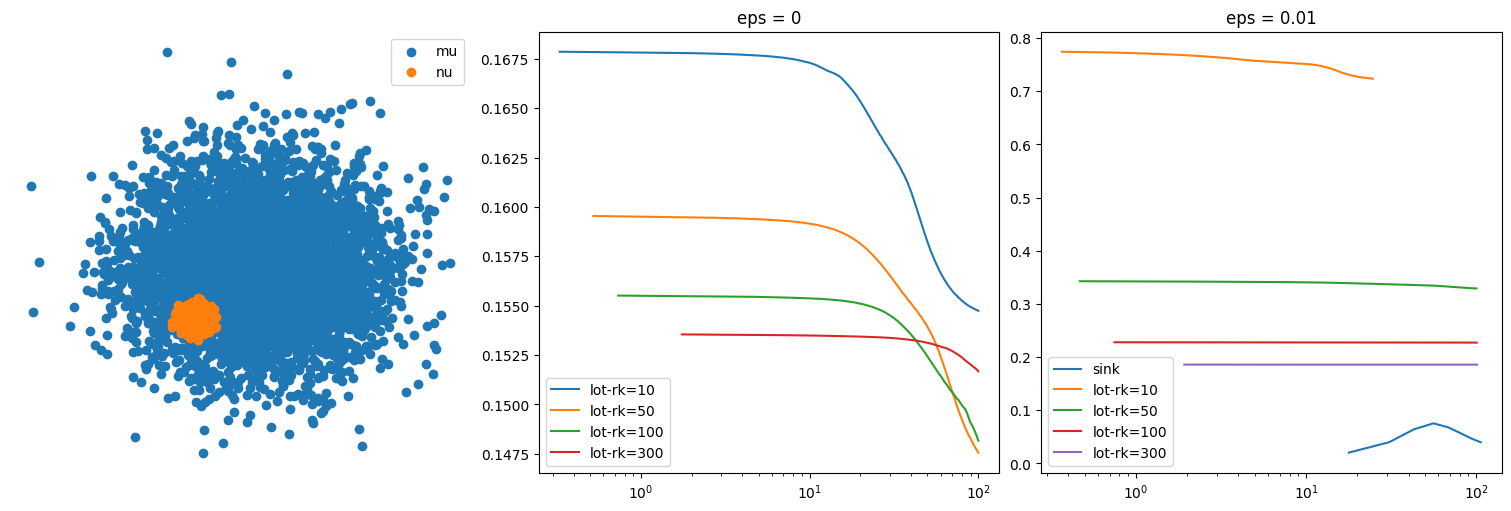

In [68]:
plt.figure(constrained_layout=True, figsize=(15, 5))

plt.subplot(131)
plt.scatter(X[:,0], X[:, 1], label='mu')
plt.scatter(Y[:,0], Y[:, 1], label='nu')
plt.legend(loc='best')
plt.axis("off")

plt.subplot(132)
plt.title("eps = 0")
for i in range(len(rank_list)):
    rank = rank_list[i]
    plt.plot(times_lot_sec[i], cost_lot_sec[i], label=f"lot-rk={rank}")
plt.legend(loc="best")
plt.semilogx()

plt.subplot(133)
plt.title("eps = 0.01")
plt.plot(times_sin, cost_sin, label="sink")
for i in range(len(rank_list)):
    rank = rank_list[i]
    plt.plot(times_lot[i], cost_lot[i], label=f"lot-rk={rank}")
plt.legend(loc="best")
plt.semilogx()

plt.savefig("result/time_evolution")
plt.show()